[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/Weather.ipynb)

#Getting Ready

In [0]:
# Installs
!pip install -U -q PyDrive

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout
from keras.models import Sequential
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from io import StringIO
import keras.utils as utils
from keras import optimizers

In [0]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [0]:
temperature_file = [(file['title'], file['id']) for file in file_list if file['title'].find('daily-minimum-temperatures')>=0]

In [8]:
f = drive.CreateFile({'id': temperature_file[0][1]})
content = f.GetContentString()
dataIO = StringIO(content)
df = pd.read_csv("daily-minimum-temperatures-in-me.csv", error_bad_lines=False)

b'Skipping line 3653: expected 2 fields, saw 3\n'


**Alternatively, if the files are available locally on the machine, just:**

In [0]:
df = pd.read_csv(dataIO, error_bad_lines=False)

In [9]:
df.describe()

Date  \
count         3650   
unique        3650   
top     1986-07-09   
freq             1   

       Daily minimum temperatures in Melbourne, Australia, 1981-1990  
count                                                3650             
unique                                                230             
top                                                  10.0             
freq                                                   51

In [0]:
x_no_qm = [value[1].replace('?','') for value in df.values]
x_train_float = np.array([float(x) for x in x_no_qm])
#x_train_norm = utils.normalize(x_train_float, axis=0, order=2)
#x_train_reshaped = np.reshape(x_train_norm, (x_train_norm.shape[1],1))
x_train_reshaped = np.reshape(x_train_float, (x_train_float.shape[0],1))

In [0]:
context_length = 100
y_train = x_train_reshaped[context_length:,:]
train_np_expanded = np.repeat(x_train_reshaped[:,np.newaxis], context_length, 1)
for i in range(1,context_length):
    train_np_expanded[:-i,i,:] = train_np_expanded[i:,i,:]
x_train = train_np_expanded[:-context_length,:,:]

Text(0.5,1,'Daily minimum temperatures in Melbourne, Australia')

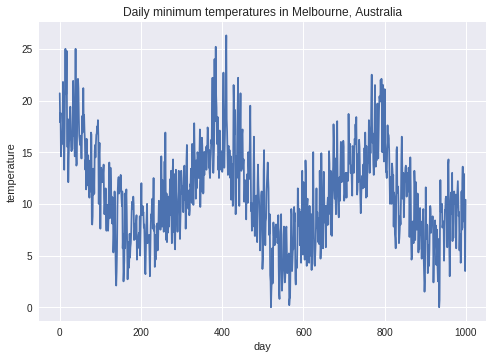

In [60]:
plt.plot(x_train_reshaped[:1000])
plt.xlabel("day")
plt.ylabel("temperature")
plt.title("Daily minimum temperatures in Melbourne, Australia")

# Model

In [0]:
def get_model(c):
    model = Sequential()
    model.add(LSTM(64, input_shape=(c,1), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    return model

# Experiment

In [0]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = get_model(context_length)
#model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=sgd)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 64)           16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_train, y_train, epochs=50)

Epoch 1/50
3550/3550 [==============================] - 16s 5ms/step - loss: 16.1332
Epoch 2/50
3550/3550 [==============================] - 16s 5ms/step - loss: 9.3858
Epoch 3/50
3550/3550 [==============================] - 16s 5ms/step - loss: 8.9843
Epoch 4/50
3550/3550 [==============================] - 16s 5ms/step - loss: 8.6626
Epoch 5/50
 576/3550 [===>..........................] - ETA: 13s - loss: 7.8421

3550/3550 [==============================] - 16s 5ms/step - loss: 8.0470
Epoch 6/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.8844
Epoch 7/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.8740
Epoch 8/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.5621
Epoch 9/50
1120/3550 [========>.....................] - ETA: 10s - loss: 7.5090

3550/3550 [==============================] - 16s 5ms/step - loss: 7.6164
Epoch 10/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.4639
Epoch 11/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.3621
Epoch 12/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.2575
Epoch 13/50
1152/3550 [========>.....................] - ETA: 10s - loss: 7.5958

3550/3550 [==============================] - 16s 5ms/step - loss: 7.2094
Epoch 14/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.2652
Epoch 15/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.0944
Epoch 16/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.1414
Epoch 17/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.8675

3550/3550 [==============================] - 16s 5ms/step - loss: 7.0728
Epoch 18/50
3550/3550 [==============================] - 16s 5ms/step - loss: 7.0286
Epoch 19/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.9668
Epoch 20/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.8638
Epoch 21/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.9627

3550/3550 [==============================] - 16s 5ms/step - loss: 7.0914
Epoch 22/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.8407
Epoch 23/50
3550/3550 [==============================] - 16s 4ms/step - loss: 6.7911
Epoch 24/50
3550/3550 [==============================] - 16s 4ms/step - loss: 6.7267
Epoch 25/50
1152/3550 [========>.....................] - ETA: 10s - loss: 7.0302

3550/3550 [==============================] - 16s 4ms/step - loss: 6.7619
Epoch 26/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.7341
Epoch 27/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.8602
Epoch 28/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.7335
Epoch 29/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.8561

3550/3550 [==============================] - 16s 5ms/step - loss: 6.5676
Epoch 30/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.6952
Epoch 31/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5290
Epoch 32/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.6530
Epoch 33/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.4064

3550/3550 [==============================] - 16s 5ms/step - loss: 6.5556
Epoch 34/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.7350
Epoch 35/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.6429
Epoch 36/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5656
Epoch 37/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.8553

3550/3550 [==============================] - 16s 5ms/step - loss: 6.6176
Epoch 38/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5988
Epoch 39/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5949
Epoch 40/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.3738
Epoch 41/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.4438

3550/3550 [==============================] - 16s 5ms/step - loss: 6.5375
Epoch 42/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5676
Epoch 43/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5094
Epoch 44/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.4629
Epoch 45/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.6125

3550/3550 [==============================] - 16s 5ms/step - loss: 6.6790
Epoch 46/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.4939
Epoch 47/50
3550/3550 [==============================] - 16s 4ms/step - loss: 6.3883
Epoch 48/50
3550/3550 [==============================] - 16s 4ms/step - loss: 6.5078
Epoch 49/50
1152/3550 [========>.....................] - ETA: 10s - loss: 6.2837

3550/3550 [==============================] - 16s 5ms/step - loss: 6.4123
Epoch 50/50
3550/3550 [==============================] - 16s 5ms/step - loss: 6.5350


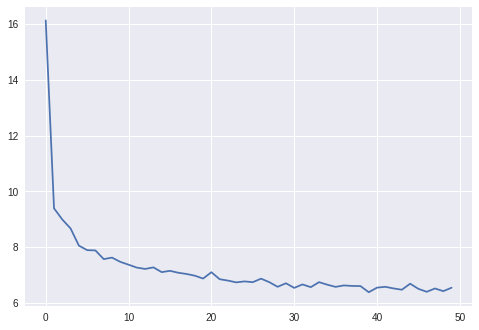

In [20]:
plt.plot(history.history['loss'])

In [21]:
plt.plot(history.history['val_loss'])

KeyError: ignored

In [22]:
model.evaluate(x=x_train, y=y_train)

3550/3550 [==============================] - 3s 727us/step


5.855141941124285

# Results

In [0]:
Ty = x_train_reshaped.shape[0]
y_pred = list()
for y in range(Ty):
    example = np.reshape(train_np_expanded[y,:,:], (1,context_length,1))
    y_pred.append(model.predict(example).tolist()[0][0])

Text(0,0.5,'weather series')

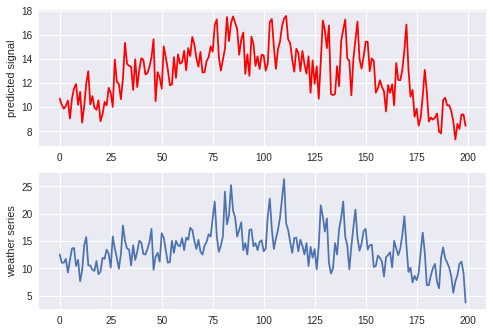

In [30]:
plt.subplot(2,1,1)
plt.plot(y_pred[:200],'r')
plt.ylabel("predicted signal")
plt.subplot(2,1,2)
plt.plot(x_train_reshaped[context_length:200+context_length])
plt.ylabel("weather series")

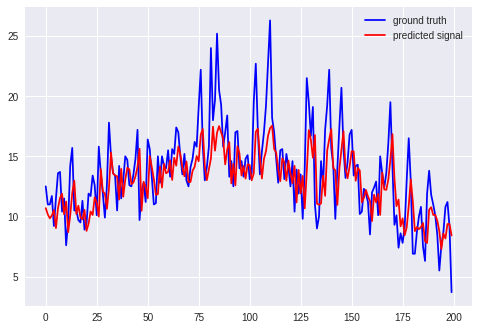

In [31]:
plt.plot(range(200),x_train_reshaped[context_length:200+context_length],'b',range(200),y_pred[:200],'r')
plt.legend(("ground truth","predicted signal"))

Text(0,0.5,'weather series')

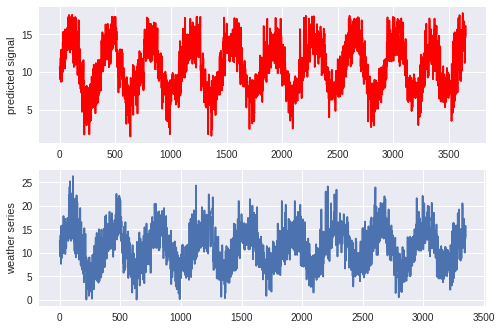

In [32]:
plt.subplot(2,1,1)
plt.plot(y_pred,'r')
plt.ylabel("predicted signal")
plt.subplot(2,1,2)
plt.plot(x_train_reshaped[context_length:])
plt.ylabel("weather series")